<center><img src='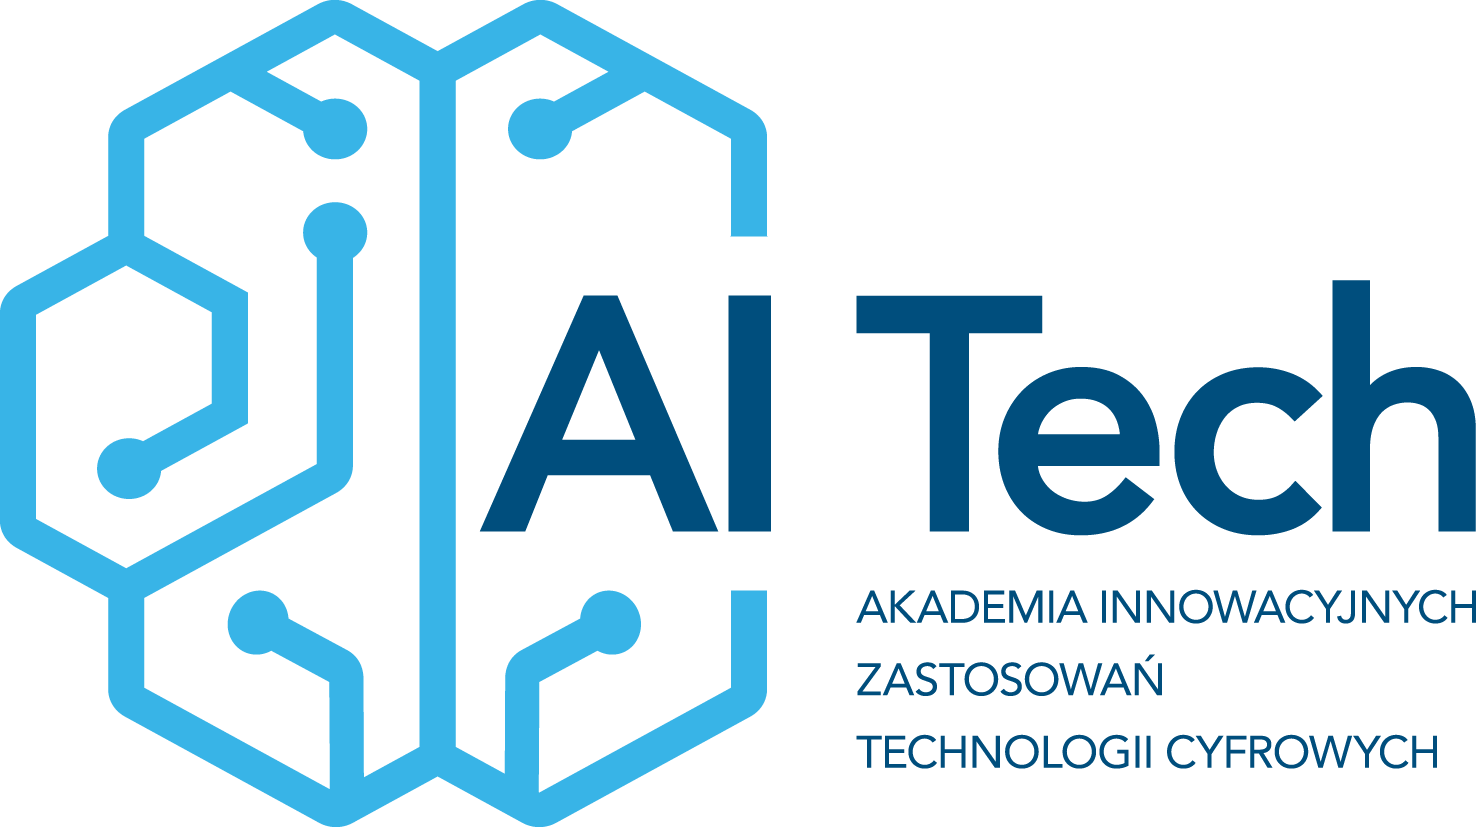
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>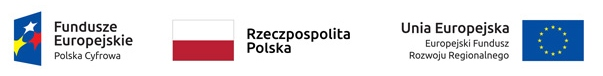</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Jacek Sroka**



To **edit the colab** first copy it to your drive with the top bars `File -> Save a copy on drive` option.

# PDD - LAB 5

Plan

1. Installation
2. Dataset
3. Distributing clustering
4. MLlib and clustering in Spark
5. Homework

In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
!pip install scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Installation


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "1g") \
                    .appName("mlibs") \
                    .getOrCreate()

## Dataset

In [ ]:
from sklearn import datasets
iris_raw = datasets.load_iris()
iris_raw

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

## Data visualization

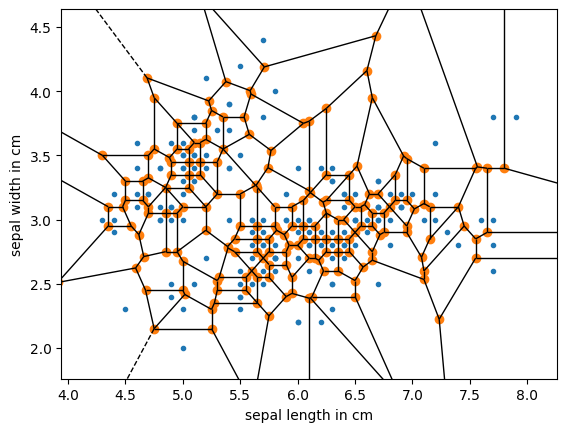

None

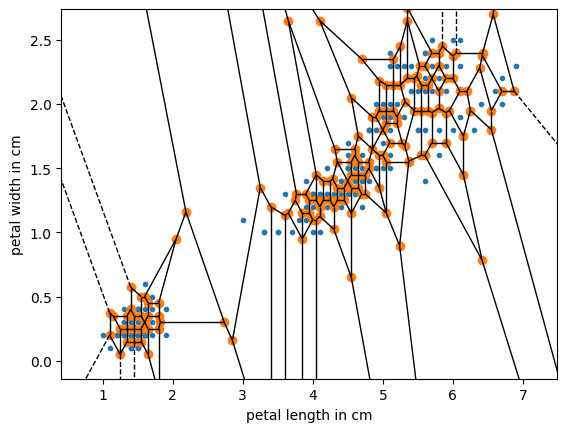

None

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

features = iris_raw.data[:,:2]
labels = iris_raw.target

vor = Voronoi(features)
voronoi_plot_2d(vor)
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')

display(plt.show())

features = iris_raw.data[:,2:]
labels = iris_raw.target

vor = Voronoi(features)
voronoi_plot_2d(vor)
plt.xlabel("petal length in cm")
plt.ylabel("petal width in cm")

display(plt.show())

In [ ]:
import pandas as pd
import plotly.express as px

iris = pd.DataFrame(iris_raw.data, columns=iris_raw.feature_names)
iris['Species'] = [iris_raw.target_names[x] for x in iris_raw.target]
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


## Centralized clustering

### Principal Component Analysis

[Link to documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [ ]:
from sklearn.decomposition import PCA

# in practise we should consider doing data scalling first (the docs says it is only centered)
iris_pca = PCA(n_components=2)
print(iris.iloc[:, :4])
iris_scores = iris_pca.fit_transform(iris.iloc[:, :4])
print(iris_pca.components_)
print(iris_pca.explained_variance_)
print(iris_pca.explained_variance_ratio_)
print(iris_scores[:10])

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]
[[ 0.36138659 -0.08452251  0.85667061  0

### KMeans (local example)

[Link to documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [ ]:
from sklearn.cluster import KMeans

iris_km = KMeans(n_clusters=3, init="k-means++", n_init="auto").fit(iris.iloc[:,:4])
iris["Cluster"] = iris_km.labels_
print(iris)

center_scores = iris_pca.transform(iris_km.cluster_centers_)
print("Cluster centers:")
print(center_scores)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

       Species  Cluster  
0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [ ]:
fig = px.scatter(iris, x=iris_scores[:,0], y=iris_scores[:,1],
                 color="Species", symbol="Cluster")
fig.add_scatter(x=center_scores[:,0], y=center_scores[:,1],
                mode='markers',
                marker={'color': 'white',
                        'line': {'color': 'black', 'width': 2},
                        'size': 12,
                        'symbol': 'x'},
                name='Cluster centers')

In [ ]:
iris.iloc[:,:5]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Silhouette score

[Link to documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [ ]:
from sklearn.metrics import silhouette_score

sc = spark.sparkContext
irisBroadcast = sc.broadcast(iris.iloc[:,:4])

def run_kmeans(k):
  iris_km = KMeans(n_clusters=k, init="k-means++").fit(irisBroadcast.value)
  silhouette_avg = silhouette_score(irisBroadcast.value, iris_km.labels_)
  return (k, silhouette_avg)


k = sc.parallelize(range(2, 11))
results = k.map(run_kmeans).collect()

results_df = pd.DataFrame(results, columns =["k", "silhouette score"])
fig = px.line(results_df, x="k", y="silhouette score")
fig.show()

# parameters = {"n_clusters":[2, 3, 4, 5, 6, 7, 8, 9, 10, 11], "init": ["k-means++"]}

## MLlib and clustering in Spark


In [ ]:
iris = iris.iloc[:,:5]
iris["Species"] = iris["Species"].apply(str)
iris.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
Species               object
dtype: object

In [ ]:
spark_df=spark.createDataFrame(iris)
spark_df.show(5,True)
spark_df.printSchema()
spark_df.describe().show()

+-----------------+----------------+-----------------+----------------+-------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|Species|
+-----------------+----------------+-----------------+----------------+-------+
|              5.1|             3.5|              1.4|             0.2| setosa|
|              4.9|             3.0|              1.4|             0.2| setosa|
|              4.7|             3.2|              1.3|             0.2| setosa|
|              4.6|             3.1|              1.5|             0.2| setosa|
|              5.0|             3.6|              1.4|             0.2| setosa|
+-----------------+----------------+-----------------+----------------+-------+
only showing top 5 rows

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- Species: string (nullable = true)

+-------+-------

See [docs](https://spark.apache.org/docs/latest/mllib-data-types.html) on data types.

In [ ]:
from pyspark.ml.linalg import Vectors

# convert the data to dense vectors, with variety
def transform_data(data):
    return data.rdd.map(lambda r: (Vectors.dense(r[:-1]), r[-1])).toDF(['features','variety'])

# convert the data to dense vectors, no variety
def transform_data2(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

transformed = transform_data(spark_df)
transformed.show(5, False)
transformed.printSchema()

+-----------------+-------+
|features         |variety|
+-----------------+-------+
|[5.1,3.5,1.4,0.2]|setosa |
|[4.9,3.0,1.4,0.2]|setosa |
|[4.7,3.2,1.3,0.2]|setosa |
|[4.6,3.1,1.5,0.2]|setosa |
|[5.0,3.6,1.4,0.2]|setosa |
+-----------------+-------+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- variety: string (nullable = true)



See [docs](https://spark.apache.org/docs/latest/ml-clustering.html) clustering.

Cluster Centers  2
[6.30103093 2.88659794 4.95876289 1.69587629]
[5.00566038 3.36981132 1.56037736 0.29056604]

+-----------------+-------+----------+
|         features|variety|prediction|
+-----------------+-------+----------+
|[5.1,3.5,1.4,0.2]| setosa|         1|
|[4.9,3.0,1.4,0.2]| setosa|         1|
|[4.7,3.2,1.3,0.2]| setosa|         1|
|[4.6,3.1,1.5,0.2]| setosa|         1|
|[5.0,3.6,1.4,0.2]| setosa|         1|
|[5.4,3.9,1.7,0.4]| setosa|         1|
|[4.6,3.4,1.4,0.3]| setosa|         1|
|[5.0,3.4,1.5,0.2]| setosa|         1|
|[4.4,2.9,1.4,0.2]| setosa|         1|
|[4.9,3.1,1.5,0.1]| setosa|         1|
|[5.4,3.7,1.5,0.2]| setosa|         1|
|[4.8,3.4,1.6,0.2]| setosa|         1|
|[4.8,3.0,1.4,0.1]| setosa|         1|
|[4.3,3.0,1.1,0.1]| setosa|         1|
|[5.8,4.0,1.2,0.2]| setosa|         1|
|[5.7,4.4,1.5,0.4]| setosa|         1|
|[5.4,3.9,1.3,0.4]| setosa|         1|
|[5.1,3.5,1.4,0.3]| setosa|         1|
|[5.7,3.8,1.7,0.3]| setosa|         1|
|[5.1,3.8,1.5,0.3]| setosa|   

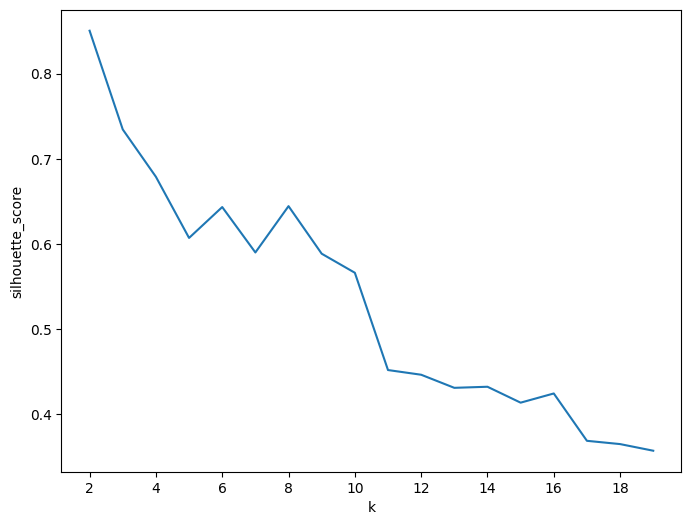

In [ ]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("features")\
            .setPredictionCol("prediction")

    model = kmeans.fit(transformed)

    print("Cluster Centers ", k)
    centers = model.clusterCenters()
    for center in centers:
        print(center)
    print()

    # Make predictions
    predictions = model.transform(transformed)
    predictions.show()

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("features")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [ ]:
kmeans = KMeans()\
        .setK(3)\
        .setSeed(1)\
        .setFeaturesCol("features")\
        .setPredictionCol("prediction")

model = kmeans.fit(transformed)
predictions = model.transform(transformed)
predictions.show(160)

+-----------------+----------+----------+
|         features|   variety|prediction|
+-----------------+----------+----------+
|[5.1,3.5,1.4,0.2]|    setosa|         1|
|[4.9,3.0,1.4,0.2]|    setosa|         1|
|[4.7,3.2,1.3,0.2]|    setosa|         1|
|[4.6,3.1,1.5,0.2]|    setosa|         1|
|[5.0,3.6,1.4,0.2]|    setosa|         1|
|[5.4,3.9,1.7,0.4]|    setosa|         1|
|[4.6,3.4,1.4,0.3]|    setosa|         1|
|[5.0,3.4,1.5,0.2]|    setosa|         1|
|[4.4,2.9,1.4,0.2]|    setosa|         1|
|[4.9,3.1,1.5,0.1]|    setosa|         1|
|[5.4,3.7,1.5,0.2]|    setosa|         1|
|[4.8,3.4,1.6,0.2]|    setosa|         1|
|[4.8,3.0,1.4,0.1]|    setosa|         1|
|[4.3,3.0,1.1,0.1]|    setosa|         1|
|[5.8,4.0,1.2,0.2]|    setosa|         1|
|[5.7,4.4,1.5,0.4]|    setosa|         1|
|[5.4,3.9,1.3,0.4]|    setosa|         1|
|[5.1,3.5,1.4,0.3]|    setosa|         1|
|[5.7,3.8,1.7,0.3]|    setosa|         1|
|[5.1,3.8,1.5,0.3]|    setosa|         1|
|[5.4,3.4,1.7,0.2]|    setosa|    

See [docs](https://spark.apache.org/docs/latest/ml-features.html) on Extracting, transforming and selecting features.

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(transformed)

# rescale each feature to range [min=0, max=1].
scaledData = scalerModel.transform(transformed).cache()

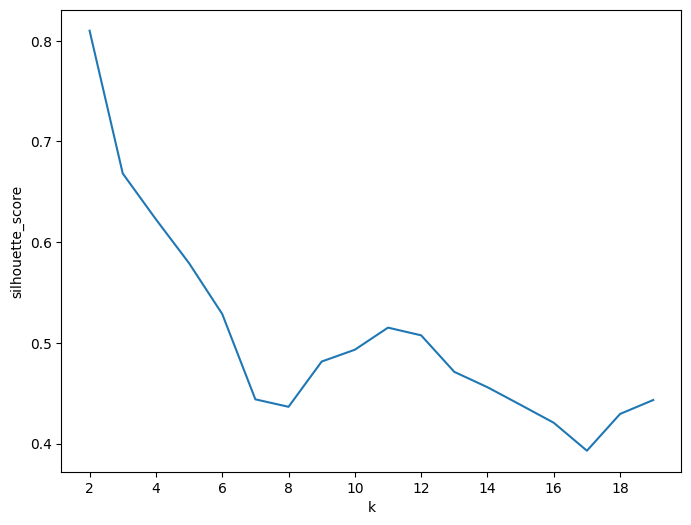

In [ ]:
silhouette_score = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("scaledFeatures")\
            .setPredictionCol("prediction")

    model = kmeans.fit(scaledData)

    # Make predictions
    predictions = model.transform(scaledData)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("scaledFeatures")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Homework



1. Convert the k-means example from this notebook into a pipeline using `spark.ml.Pipeline` ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html), [example](https://spark.apache.org/docs/latest/ml-pipeline.html#pipeline)), `CrossValidator` ([docs](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)) and `ParamGridBuilder` ([docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) to do grid search over the `k` parameter. Note: you can use the `avgMetrics` property of the fitted model to find the shilouette values for the tested `k` values.

Further reading on the Spark ML pipelines, and more examples: https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/

2. Experiment with other clustering algorithms from  https://spark.apache.org/docs/latest/ml-clustering.html (try at least 2 other).


Further reading:

*   https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e (one hot encoder explanation)
*   https://george-jen.gitbook.io/data-science-and-apache-spark/train-validation-split
*   https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation
*   New algorithm for k-means in Map-Reduce - won the best paper award on EuroPar 2023 https://arxiv.org/abs/2202.08173

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>